In [3]:
using Plots
using LaTeXStrings
using DifferentialEquations
theme(:mute)

# Modelo de Hodgkin-Huxley

\begin{align*}
 C_m \frac{dV}{dt} &= -g_{Na}m^3h(V-E_{Na}) - g_K n^4 (V - E_K) \\
                   &- g_L (V - E_L) + I_{ext} \\
 \frac{1}{\gamma(T)} \frac{dn}{dt} &= \alpha_n(V) (1 - n) - \beta_n(V)n = \frac{n^{\infty}(V) - n}{\tau_n(V)} \\
 \frac{1}{\gamma(T)} \frac{dm}{dt} &= \alpha_m(V) (1 - m) - \beta_m(V)m = \frac{m^{\infty}(V) - m}{\tau_m(V)} \\
 \frac{1}{\gamma(T)} \frac{dh}{dt} &= \alpha_h(V) (1 - h) - \beta_h(V)h = \frac{h^{\infty}(V) - h}{\tau_h(V)} \\
 \tau_n(V) &= \frac{1}{\alpha_n(V) + \beta_n(V)} \\
 n_{\infty}(V) &= \frac{\alpha_n(V)}{\alpha_n(V) + \beta_n(V)}
\end{align*}

Con [Wells]:
* $C_m = 1.0\ \mu\text{F/cm}^2$ la capacitancia de la membrana por unidad de área
* $V$ la diferencia de potencial en la membrana
* $g_{Na} = 120\ \text{mS/cm}^2$ la conductancia máxima por unidad de área para el sodio
* $g_{K} = 36\ \text{mS/cm}^2$ la conductancia máxima por unidad de área para el potasio
* $g_{L} = 0.3\ \text{mS/cm}^2$ la conductancia adicional, independiente del voltaje
* $E_{Na} = 55\ \text{mV}$ el voltaje de la batería en la compuerta de sodio
* $E_{K} = -72\ \text{mV}$ el voltaje de la batería en la compuerta de potasio
* $E_{L} = -49.387\ \text{mV}$ el voltaje filtrado
* $\gamma(T)$ es una constante de proporcionalidad temporal que depende de la temperatura $T$, a $6.3°$C vale $1$ [Cessac2009].

para el caso del calamar.  Los potenciales están medidos considerando que la membrana se encuentra en su potencial de reposo a los $V_r = -60\ \text{mV}$.  Las corrientes $I$ están medidas en $\mu$A/cm$^2$.

Las funciones de transición $\alpha(V)$ y $\beta(V)$, fueron determinadas experimentalmente.  Su forma general es:
\begin{align}
  \alpha(V) \text{ ó } \beta(V) = \frac{A + BV}{C + H e^{\left(\frac{V+D}{F}\right)}}
\end{align}
donde $V$ está medido con respecto al potencial de reposo $V_r$

Los valores medidos por Hodkin y Huxley para la compuerta de **potasio (K)**, fueron:
\begin{align}
  \alpha_n(V) &= \frac{0.01(10 - V)}{e^{\left(\frac{10-V}{10}\right)} - 1} & \beta_n(V) &= 0.125 e^{-\frac{V}{80}}
\end{align}
Observemos que cuando $V = 10$ la función está indefinida.  Utilizando la regla de L'Hopital, se calcula el límite:
\begin{align}
  \alpha_n(10) &= \frac{-0.01}{e^{\left(\frac{10-V}{10}\right)}(-0.1)}
               = \frac{-0.01}{-0.1} = 0.1
\end{align}

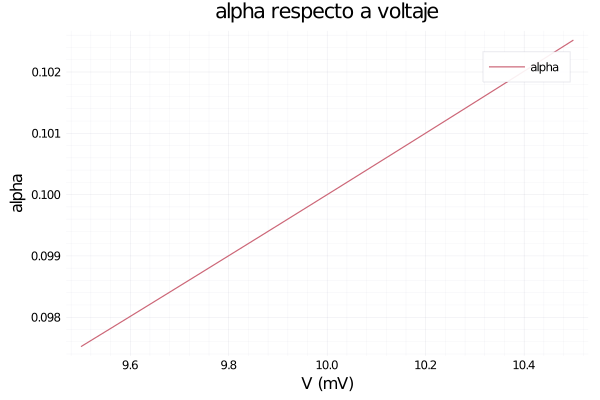

In [4]:
#= Programa las función alfa_n como función del voltaje V.
Necesitarás definir un caso especial cuando V - 10 < epsilon
Utiliza esta celda para ver como se comporta tu función en esta vecindad y elegir un valor de epsilon adecuado. =#

function alpha_n(V)
    ε=0.001
    
    if abs(V-10)<ε
        α=0.1
    else
        α=(0.01(10-V))/(exp((10-V)/10)-1)
    end
    
    return α
end

plot(alpha_n, 9.5:0.01:10.5, xaxis="V (mV)",yaxis="alpha", title="alpha respecto a voltaje", label="alpha")

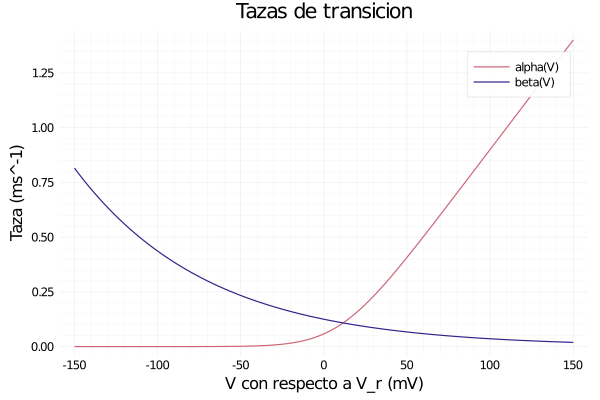

In [5]:
#= Programa las funciones como función del voltaje V, para la compuerta de K
Genera luego una gráfica de alfa_n y beta_n. =#

function beta_n(V)
    β=0.125*exp(-V/80)
    return β
end

function plotAlpha()
    V = -150:150
    plot(V,alpha_n,title="Tazas de transicion", xlabel="V con respecto a V_r (mV)", ylabel="Taza (ms^-1)", label="alpha(V)")
    plot!(V,beta_n,label="beta(V)")
end

plotAlpha()

Las funciones para el **sodio (Na)** son:
\begin{align}
  \alpha_m(V) &= \frac{0.1(25 - V)}{e^{\left(\frac{25-V}{10}\right)} - 1} & \beta_m(V) &= 4 e^{-\frac{V}{18}} \\
  \alpha_h(V) &= 0.07 e^{-\frac{V}{20}} & \beta_h(V) &= \frac{1}{e^{\left(\frac{30-V}{10}\right)} + 1}
\end{align}
Para $\alpha_m$ cuando $V = 25$, utilizamos la regla de L'Hopital para calcular el límite:
\begin{align}
  \alpha_m(25) &= \frac{-0.1}{e^{\left(\frac{25-V}{10}\right)}(-0.1)}
               = \frac{-0.1}{-0.1} = 1
\end{align}

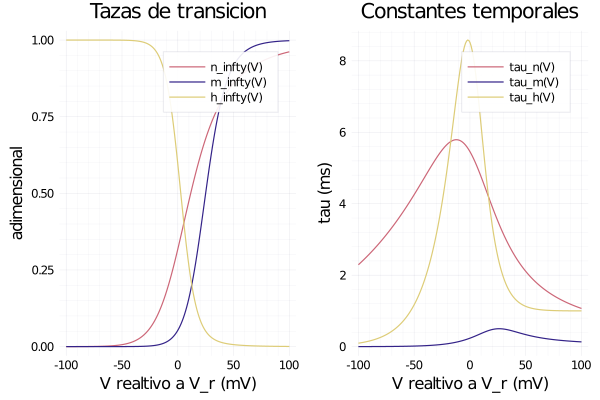

In [6]:
#= Dadas alfa y beta, calcular ahora y graficar n y tau para ambos canales.
Agrega las funciones correspondientes para la compuerta de sodio también, deduce sus firmas a partir de las llamadas 
en la función para graficar. =#

function alpha_m(V)
    ε=0.001
    
    if abs(V-25)<ε
        α_m=1
    else
        α_m=(0.1*(25-V))/(exp((25-V)/10)-1)
    end
    
    return α_m
end


function beta_m(V)
    β_m=4*exp(-V/18)
    return β_m
end


function alpha_h(V)
    α_h=0.07*exp(-V/20)
    return α_h
end


function beta_h(V)
    β_h=1/(exp((30-V)/10)+1)
    return β_h
end


function tau_inf(alpha, beta)
    tau_n= 1/(alpha + beta)
    return tau_n
end


function n_inf(alpha, beta)
    n_inf=alpha/(alpha + beta)
    return n_inf
end


function plotParameters()    
    V = -100:100
    
    n_inf_n(V) = n_inf(alpha_n(V), beta_n(V))
    tau_inf_n(V) = tau_inf(alpha_n(V), beta_n(V))
    
    n_inf_m(V) = n_inf(alpha_m(V), beta_m(V))
    tau_inf_m(V) = tau_inf(alpha_m(V), beta_m(V))
    
    n_inf_h(V) = n_inf(alpha_h(V), beta_h(V))
    tau_inf_h(V) = tau_inf(alpha_h(V), beta_h(V))
    
    p1 = plot(
        V,
        [n_inf_n, n_inf_m, n_inf_h],
        label=["n_infty(V)" "m_infty(V)" "h_infty(V)"]
    )
    
    p2 = plot(
        V,
        [tau_inf_n, tau_inf_m, tau_inf_h],
        label=["tau_n(V)" "tau_m(V)" "tau_h(V)"]
    )
    
    plot(
        p1,
        p2,
        layout=(1, 2),
        title=["Tazas de transicion" "Constantes temporales"],
        xlabel=["V realtivo a V_r (mV)" "V realtivo a V_r (mV)"],
        ylabel=["adimensional" "tau (ms)"],
        legend=true
    )
end


plotParameters()

![tasas_constantes](figuras/tazas-y-constantes.jpg)

## Simulación con el método numérico de Euler

El método de Euler realiza una aproxima a la función por su tangente.  Dada una ecuación diferencial de la forma:

\begin{align}
  \frac{dy(t)}{dt} = f(y(t))
\end{align}

Partimos de un punto inicial $(t_0, y_0)$ y a partir de él, se calcula el valor de $y$ para el tiempo $t + \Delta t$ iterativamente como:

\begin{align}
  y(t + \Delta t) &= y(t) + \Delta t f(y(t))
\end{align}

El error aproximado por realizar esta aproximación es:
\begin{align}
  E =& \frac{1}{2} \frac{df(t)}{dt}(\Delta t)^2
\end{align}

Aplicando esta fórmula a la ecuación para los canales:

\begin{align}
 \frac{dn}{dt} &= \frac{n^{\infty}(V) - n}{\tau_n(V)}
\end{align}

Obtenemos:

\begin{align}
 n(t + \Delta t) =& n(t) + \Delta t \left[\frac{n^{\infty}(V)}{\tau_n} - \frac{n(t)}{\tau_n(V)} \right] \\
                 =& \left[ 1 - \frac{\Delta t}{\tau_n(V)} \right] n(t) + \frac{\Delta t}{\tau_n(V)}n^{\infty}(V)
\end{align}

Se obtienen fórmulas análogas para $m$ y $h$.  Todas juntas pueden ser escritas en forma matricial:

\begin{align}
  \begin{bmatrix}
  n(t + \Delta t) \\
  m(t + \Delta t) \\
  h(t + \Delta t)
  \end{bmatrix} =& 
  \begin{bmatrix}
  (1 - \Delta t/\tau_n(V)) & 0 & 0 \\
  0 & (1 - \Delta t/\tau_m(V)) & 0 \\
  0 & 0 & (1 - \Delta t/\tau_h(V)) \\
  \end{bmatrix}
  \begin{bmatrix}
  n(t) \\
  m(t) \\
  h(t)
  \end{bmatrix} +
  \begin{bmatrix}
  (\Delta t / \tau_n(V)) n^{\infty}(V) \\
  (\Delta t / \tau_m(V)) m^{\infty}(V) \\
  (\Delta t / \tau_h(V)) h^{\infty}(V)
  \end{bmatrix}
\end{align}

Brevemente:

\begin{align}
  \boldsymbol{\Pi}(t + \Delta t) =& \boldsymbol{A}_\pi \boldsymbol{\Pi}(t) + \boldsymbol{B}_\pi
\end{align}

Se debe realizar el mismo procedimiento con la ecuación diferencial para el voltaje.  Para simplificar la notación, introduzcamos:

\begin{align}
  G_{Na} &= g_{Na}m^3h   &   G_{K} &= g_K n^4
\end{align}

Entonces:
\begin{align}
 C_m \frac{dV}{dt} &= -g_{Na}m^3h(V-E_{Na}) - g_K n^4 (V - E_K) - g_L (V - E_L) + I_{ext} \\
 \frac{dV}{dt} &= -\frac{G_{Na}}{C_m}(V-E_{Na}) - \frac{G_K}{C_m} (V - E_K) - \frac{g_L}{C_m} (V - E_L) + \frac{1}{C_m}I_{ext}
\end{align}

Utilizando el método de Euler:

\begin{align}
 V(t + \Delta t) &= V(t) - \frac{\Delta t}{C_m} \left[ G_{Na}(V-E_{Na}) + G_K (V - E_K) + g_L (V - E_L) + I_{ext}(t) \right] \\
 V(t + \Delta t) &= V(t) - \Delta t \begin{bmatrix} \frac{G_{Na}}{C_m} & \frac{G_K}{C_m} & \frac{g_L}{C_m} \end{bmatrix}  \begin{bmatrix}
                 V(t)-E_{Na} \\
                 V(t)- E_K \\
                 V(t) - E_L
                \end{bmatrix} + \frac{\Delta t}{C_m}I_{ext}(t)
\end{align}

Para los valores por defecto propuestos en la celda siguiente, programar una simulación utilizando el método de Euler produce la figura siguiente:

![simulacion](figuras/Simulacion.png)

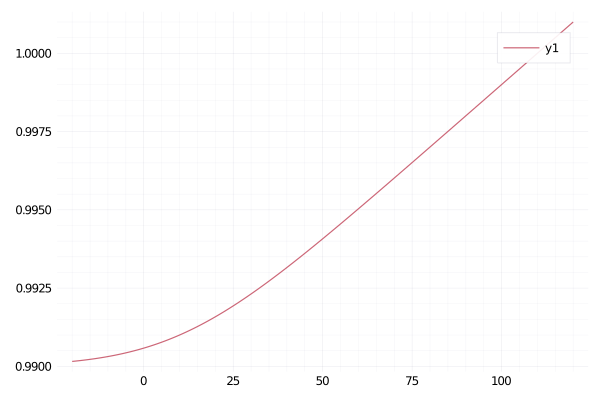

In [7]:
function N(V)
    N0=1
    N=(1-0.01)*N0 + (0.01*n_inf(alpha_n(V), beta_n(V))/tau_inf(alpha_n(V), beta_n(V)))
    return N
end

plot(-20:120,N)

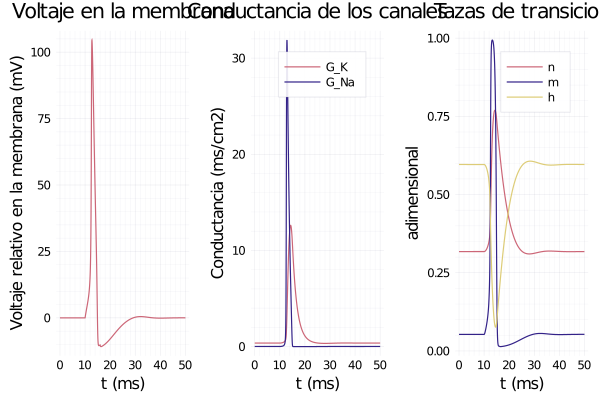

In [8]:
#definimos las constantes usando la función const 
const DeltaT = 0.01 #ms
const maxT = 50.0 #ms
const V0= 0.0 #mV
const gNa= 120.0 #mS/cm2
const gK= 36.0 
const gL= 0.3
const Cm= 1.0 #micro F/cm2
const ENa=115.0 # Utilizando la convensión original de Hodkin-Huxley
const EK=-12.0
const EL=10.613

#Se usaran las funciones previamente definidas
# Adicionalmente se definieron n_inf para n, m y h 
n_inf_n(V) = n_inf(alpha_n(V), beta_n(V))
n_inf_m(V) = n_inf(alpha_m(V), beta_m(V))
n_inf_h(V) = n_inf(alpha_h(V), beta_h(V))

#Definimos la función de corriente 
function Iext(t)
    t0= 10.0
    tfin= 16.0
    current= 6.5
    """ Devuelve el valor de la corriente aplicada a la membrana, al tiempo t, en microampers."""
    if (t>t0) & (t<tfin)
        return current # micro A/cm2
    else 
        return 0
    end
end

## Implementa aquí el algoritmo de intregración numérica de Euler para calcular V(t)
##
function EulerHodkinHuxley(u, p, t)
    V0 = 0
    n,m,h,V = u 
    V_diff = V-V0
    dn = alpha_n(V_diff)*(1-n) - beta_n(V_diff)*n
    dm = alpha_m(V_diff)*(1-m) - beta_m(V_diff)*m
    dh = alpha_h(V_diff)*(1-h) - beta_h(V_diff)*h
    
    #Definimos las corrientes 
    G_K= gK * (n ^ 4.0) #conductancia de potasio 
    G_Na= gNa * (m ^ 3.0) * h #Conductancia de sodio 
    #Definimos dV utilizando la formula dada
    dV = (Iext(t) + (ENa - V)*G_Na + (EK - V)*G_K + (EL - V)*gL)/Cm 
    
    [dn;dm;dh;dV]
end

u0= [n_inf_n(0); n_inf_m(0); n_inf_h(0); 0] 
tspan = (0.0,50.0) 
prob = ODEProblem(EulerHodkinHuxley, u0, tspan) 
sol = solve(prob, saveat=0.01);


G_K_s = gK * sol[1,:].^4
G_Na_s = gNa * (sol[2,:].^ 3.0) .* sol[3,:]

function con()
plot(sol.t, G_K_s, title="Conductancia de los canales", label="G_K", xaxis="t (ms)", yaxis="Conductancia (ms/cm2)")
plot!(sol.t, G_Na_s, label="G_Na")
end

p1 = plot(sol.t, sol[4,:], legend=false, ylabel="Voltaje relativo en la membrana (mV)", xlabel= "t (ms)", title="Voltaje en la membrana")
#p3 corresponde a las tazas de transición
p2 = con()
p3 = plot(sol.t, sol[1:3,:]', label=["n" "m" "h"], legend=:topright, ylabel="adimensional", xlabel= "t (ms)", title="Tazas de transicion")

l = (1,3)
plot(p1, p2, p3, layout = l)

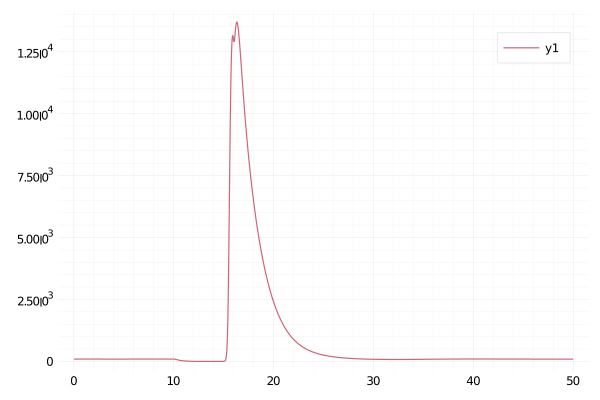

GKS: character ignored due to unicode error
GKS: character ignored due to unicode error
GKS: character ignored due to unicode error
GKS: character ignored due to unicode error
GKS: character ignored due to unicode error
GKS: character ignored due to unicode error
GKS: character ignored due to unicode error
GKS: character ignored due to unicode error
GKS: character ignored due to unicode error
GKS: character ignored due to unicode error
GKS: character ignored due to unicode error
GKS: character ignored due to unicode error
GKS: character ignored due to unicode error
GKS: character ignored due to unicode error
GKS: character ignored due to unicode error
GKS: character ignored due to unicode error
GKS: character ignored due to unicode error
GKS: character ignored due to unicode error
GKS: character ignored due to unicode error
GKS: character ignored due to unicode error
GKS: character ignored due to unicode error
GKS: character ignored due to unicode error
GKS: character ignored due to un

In [9]:
#=function taus()
    G_Na_s = gNa * (sol[2,:].^ 3.0) .* sol[3,:]
    tau_n_s= G_Na_s.*(Cm^-1)
    #=tau_m_s=
    tau_h_s==#
    plot(sol.t, tau_n_s())
end

taus()=#

tau_n_s= Cm./G_Na_s
plot(sol.t, tau_n_s)

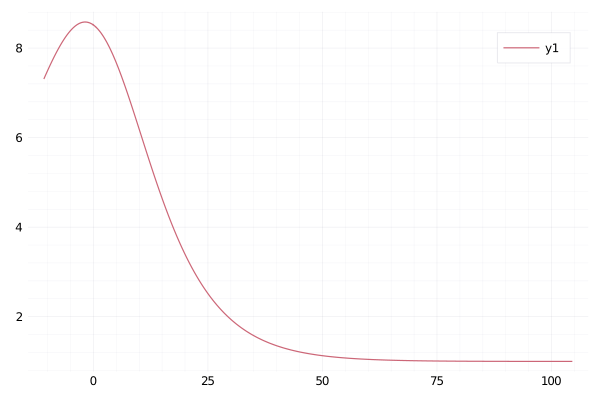

In [69]:
tau_h(V)=tau_inf(alpha_h(V), beta_h(V))

plot(sol[4,:],tau_h)

In [89]:
function t()
    for i in 1:5001
        

5001-element Vector{Float64}:
  0.0
  0.01
  0.02
  0.03
  0.04
  0.05
  0.06
  0.07
  0.08
  0.09
  0.1
  0.11
  0.12
  ⋮
 49.89
 49.9
 49.91
 49.92
 49.93
 49.94
 49.95
 49.96
 49.97
 49.98
 49.99
 50.0

In [11]:
par = Dict(
    "DeltaT" => 0.01,   # ms
    "maxT" => 50.0,     # ms    
    "V0" => 0.0,        # mV
    "gNa" => 120.0,     # mS/cm2
    "gK" => 36.0,
    "gL" => 0.3,
    "Cm" => 1.0,        # micro F/cm2
    "ENa" => 115.0,     # Utilizando la convensión original de Hodkin-Huxley
    "EK" => -12.0,
    "EL" => 10.613
)

function makeIext(t0=10.0, tfin=16.0, current=6.5)
    function Iext(t)
        """ Devuelve el valor de la corriente aplicada a la membrana, al tiempo t, en microampers.
        """
        if (t>t0) & (t<tfin)
            return current # micro A/cm2
        else
            return 0
        end
    return Iext
    end
end

makeIext (generic function with 4 methods)

In [12]:
#Aquí pienso que lo que en verdad quiere hacer la función es:

function Iext(t,t0,tfin,current)
        """ Devuelve el valor de la corriente aplicada a la membrana, al tiempo t, en microampers.
        """
        if (t>t0) & (t<tfin)
            return current # micro A/cm2
        else
            return 0
        end
end

function makeIext(t)
    t0=10.0
    tfin=16.0
    current=6.5
    return Iext(t,t0,tfin,current)
end

makeIext(11)

6.5

In [13]:
#= Implementa aquí el algoritmo de integración de Euler para calcular V(t).
Asegúrate de que, al ejecutar la simulación con los parámetros por defecto, se reproduce la imagen de arriba.
Después prueba con pulsos de t en 10->30, con corrientes de 10 y -10 microamperes. ¿Qué observas?
Inserta al final una celda con tus comentarios y resultados.=#

function EulerHodkinHuxley(par)
    """Devuelve la solucion a las ecuaciones diferenciales del modelo de Hodgkin
    y Huxley utilizando el metodo de Euler"""
    
    "T"=> 0:par["DeltaT"]:par["maxT"],
    "V"=>,
    "GK"=> par["gK"]*n^4,
    "GNa"=> par["gNa"]*m^3*h,
    "n"=>,
    "m"=>,
    "h"=>,
    "tauN"=> par["Cm"]/par["gNa"]*m^3*h,
    "tauM"=> par["Cm"]/par["gK"]*n^4,
    "tauH"=> par["Cm"]/par["gL"]
    
end
  

function plotSimulation(resultado)
    tiempo = resultado["T"]
    
    p1 = plot(tiempo, resultado["V"])
    p2 = plot(tiempo, [resultado["GK"], resultado["GNa"]], label=["G_K" L"G_Na"])
    p3 = plot(tiempo, [resultado["n"], resultado["m"], resultado["h"]], label=["n" "m" "h"])
    p4 = plot(tiempo, [resultado["tauN"], resultado["tauM"], resultado["tauH"]], label=["tau_n" "tau_m" "tau_h"])

    plot(
        p1,
        p2,
        p3,
        p4,
        layout=(2, 2),
        title=["Voltaje en la membrana" "Conductancia de los canales" "Tazas de transición" "Constantes temporales"],
        xlabel="t (ms)",
        ylabel=["Voltaje relativo en la membrana (mV)" "Conductancia (mS/cm^2)" "adimensional" "tau (ms)"],
        legend=true
    )
end
    

function simulaHodkinHuxley(V0, t0, tfin, current)
    iext_func = makeIext(t0, tfin, current)
    par["V0"] = V0
    resultado = EulerHodkinHuxley(par)
    plotSimulation(resultado)
end

V0 = 0
t0 = 10
tfin = 16 # seleccionar de: -90 a 120
current = 2.4 # seleccionar de: -10 a 10

simulaHodkinHuxley(V0, t0, tfin, current)

LoadError: syntax: unexpected ","

# Comentarios y resultados
Escribe aquí tus resultados